# Model Training and Evaluation

* [Data Loading and Final Preparation](#data-loading)
* [Model Setup](#model-setup)
* [Teeth Model](#teeth-model)
* [Abnormality Model](#abnormality-model)


In [ ]:
#!pip install cloudpathlib
#!pip install boto3
#!pip install tensorflow
#!pip install pillow
#!pip install opencv-python
#!pip install focal_loss
#!pip install albumentations

In [ ]:
# Load the required libraries
import os
import shutil
import pandas as pd
import numpy as np
from cloudpathlib import CloudPath
from cloudpathlib import S3Client
from cloudpathlib import S3Path
import matplotlib.pyplot as plt
import boto3
import glob
import PIL
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from sklearn.model_selection import train_test_split
import albumentations as A
import random
from keras import backend as K
from keras.constraints import max_norm


In [ ]:
# Set environment variables
key_data = pd.read_csv('rootkey.csv')
#os.environ['AWS_ACCESS_KEY'] = ''
#os.environ['AWS_SECRET_KEY'] = ''

<a name="data-loading"></a>
## Data Loading and Final Preparation

In [ ]:
# Create files in local storage for x-ray data after pulling data from S3 folder

def gatherS3Data(s3_path, folder_name):
  s3_client = S3Client(aws_access_key_id=os.getenv('AWS_ACCESS_KEY'), aws_secret_access_key=os.getenv('AWS_SECRET_KEY'))
  x_rays_images = s3_client.CloudPath(s3_path)
  x_rays_images.download_to(folder_name)

gatherS3Data('s3://ads-599-capstone-data/ads-599-team7/cleaned_abnormalities/', 'abnormality_masks')
gatherS3Data('s3://ads-599-capstone-data/ads-599-team7/cleaned_original/', 'original_images')
gatherS3Data('s3://ads-599-capstone-data/ads-599-team7/cleaned_teeth/', 'teeth_masks')

In [ ]:
# Load and prepare the data
img_size = (256, 256) # Set the image size
# When loading data, specify directory, dimensions (3 or 1), the datatype, and the color mode
def load_prep(directory, dim, dtype, color_mode):
  data = sorted(glob.glob(directory + '/*'))
  num_imgs = len(data)
  img_size = (256, 256)
  model_imgs = np.zeros((num_imgs,) + img_size + (dim,), dtype=dtype) # Array to copy the data into
  for i in range(num_imgs):
    if color_mode=='grayscale': # Load masks as grayscale
      img = load_img(data[i], color_mode=color_mode, target_size=img_size)
      img = img.crop((30, 50, 230, 220)) # Crop images 
      img = img.resize((256, 256)) # Resize images
      model_imgs[i] = img_to_array(img) > 100 # Filter values in the array
      model_imgs[i] = model_imgs[i].astype('uint8')
    else: # Load radiographs as rgb
      img = load_img(data[i], color_mode=color_mode, target_size=img_size)
      img = img.crop((30, 50, 230, 220)) # Crop images
      img = img.resize((256, 256)) # Resizse images
      model_imgs[i] = img_to_array(img)
  return model_imgs

# Load the original, teeth, and abnormality images
original = load_prep('original_images', 3, 'float32', 'rgb')
teeth = load_prep('teeth_masks', 1, 'uint8', 'grayscale')
abnormality = load_prep('abnormality_masks', 1, 'uint8', 'grayscale')

In [ ]:
# Filter abnormalities to include only visible masks
def subset_abnormalities(ab_list):
  filtered = []
  for i in range(len(ab_list)):
    if np.sum(ab_list[i]) > 0:
      filtered.append(i)
  return filtered

# Use the index to create filtered abnormality list and original list
subset_list = subset_abnormalities(abnormality)
ab_subset = [abnormality[i] for i in subset_list]
orig_subset = [original[i] for i in subset_list]
num_imgs = len(subset_list)
img_size = (256, 256)
ab_subset_imgs = np.zeros((num_imgs,) + img_size + (1,), dtype='uint8')
orig_subset_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype='float32')
# Read images in to arrays
for i in range(num_imgs):
  ab_subset_imgs[i] = ab_subset[i]
  orig_subset_imgs[i] = orig_subset[i]

In [ ]:
# Add new observations using augmentations
# Set augmentations
distort = A.GridDistortion(p=1)
elastic_trans = A.ElasticTransform(p=1)
hflip = A.HorizontalFlip(p=1)
aflip = A.VerticalFlip(p=1)
transpose = A.Transpose(p=1)
r90 = A.RandomRotate90(p=1)

augmentation_list = [distort, elastic_trans, hflip, aflip, transpose, r90]

# Apply transformations to each image in the original and abnormality dataset
def transform_and_create(originals, abnormalities, augmentation):
  img_size = (256,256)
  ab_aug = np.zeros((num_imgs,) + img_size + (1,), dtype='uint8')
  orig_aug = np.zeros((num_imgs,) + img_size + (3,), dtype='float32')
  for i in range(num_imgs):
    augmented = augmentation(image=originals[i], mask=abnormalities[i])
    image_aug = augmented['image']
    mask_aug = augmented['mask']
    ab_aug[i] = mask_aug
    orig_aug[i] = image_aug 

  return ab_aug, orig_aug

# Join the transformations to the original dataset
def append_transform(augmentation_list):
  original_list = [orig_subset_imgs]
  ab_list = [ab_subset_imgs]
  for i in augmentation_list:
    aug_abnormality, aug_original = transform_and_create(orig_subset_imgs, ab_subset_imgs, i)
    original_list.append(aug_original)
    ab_list.append(aug_abnormality)
  originals = np.concatenate(original_list, axis=0)
  abs = np.concatenate(ab_list, axis=0)

  return originals, abs


orig_subset_imgs, ab_subset_imgs = append_transform(augmentation_list)

In [ ]:
# Train-test-valid split of data
def train_valid_test(array_name, test_size=0.1, val_size=0.1, random_state=27):
  train, test = train_test_split(array_name, test_size=test_size, random_state=random_state)
  # Train test split again to obtain validation set
  train, val = train_test_split(train, test_size=val_size, random_state=random_state)
  return train, val, test


train_orig, val_orig, test_orig = train_valid_test(original, 0.1, 0.3, 127)
train_teeth, val_teeth, test_teeth = train_valid_test(teeth, 0.1, 0.3, 127)
train_ab, val_ab, test_ab = train_valid_test(ab_subset_imgs, 0.1, 0.3, 127)

# Subset train and valid
sub_train_orig, sub_val_orig, sub_test_orig = train_valid_test(orig_subset_imgs, 0.1, 0.3, 127)

<a name="model-setup"></a>
## Model Setup

In [ ]:
# Create up-block function (for the decoder layer)
def up_block(neurons, concat_layer, input, kernel_constraint=None, bias_constraint=None):
  up = layers.Conv2DTranspose(neurons, (2,2), strides=(2,2), activation='relu', kernel_initializer='he_normal', padding='same')(input)
  up = layers.concatenate([up, concat_layer])
  conv = layers.Conv2D(neurons, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_constraint=kernel_constraint, bias_constraint=bias_constraint)(up)
  conv = layers.Conv2D(neurons, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_constraint=kernel_constraint, bias_constraint=bias_constraint)(conv)
  conv = layers.BatchNormalization()(conv)
  return conv

In [ ]:
# Clear session as needed
keras.backend.clear_session()
# Create the encoder model as a ResNet50v2 - rescale input before feeding into encoder
inputs = keras.Input(shape=(256,256) + (3,))
x = layers.Rescaling(1./255)(inputs)
base = keras.applications.ResNet50V2(
      include_top=False,
      weights="imagenet",
      input_shape=(256,256) + (3,),
      input_tensor=x
  )
base.trainable = False

<a name="teeth-model"></a>
## Teeth Model

In [ ]:
# Set up functions to calculate Focal Tversky Loss 
# Calculate tversky
def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    tversky = (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)
    return tversky

# Tversky loss calculation
def tversky_loss(y_true, y_pred):
    tversky_loss = 1 - tversky(y_true, y_pred)
    return 

# Focal tversky loss calculation
def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    focal_tv_loss = K.pow((1 - tv), gamma)
    return focal_tv_loss

In [ ]:
#  Function for U-Net model - currently configured for abnormality model, to configure for teeth remove kernel and bias constraints
def unet_model(dropout):
  # Extract decoder path
  down0 = base.get_layer('input_1').output
  down1 = base.get_layer('conv1_conv').output
  down2 = base.get_layer('conv2_block3_1_relu').output
  down3 = base.get_layer('conv3_block4_1_relu').output
  x = base.get_layer('conv4_block6_1_relu').output 
  # Set up encoder path
  conv6 = up_block(512, down3, x, max_norm(3), max_norm(3))
  layers.Dropout(dropout)(conv6)
  conv7 = up_block(256, down2, conv6, max_norm(3), max_norm(3))
  layers.Dropout(dropout)(conv7)
  conv8 = up_block(128, down1, conv7, max_norm(3), max_norm(3))
  layers.Dropout(dropout)(conv8)
  conv9 = up_block(64, down0, conv8, max_norm(3), max_norm(3))
  layers.Dropout(dropout)(conv9)
  # Output layer with sigmoid activation
  outputs = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(conv9)

  model = keras.Model(inputs, outputs)
  return model

In [ ]:
# Get model structure and print the summary
model = unet_model(0.5)
#model.summary()

In [ ]:
# Compile and train the model for tooth detection - run first without the base model updating weights, then decrease learning rate to 0.000001 and train base
#keras.backend.clear_session()
#base.trainable = True
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=focal_tversky_loss, metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.MeanIoU(num_classes=2)])
# Save best model and stop training if no improvements in validation loss occur over 10 epochs
callback = [
    keras.callbacks.ModelCheckpoint("teeth_segmentation.keras", 
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss",
                                  patience=10)
]

teeth_model = model.fit(train_orig, tf.cast(train_teeth, 'float32'),
                        epochs=64,
                        callbacks=callback,
                        batch_size=32,
                        validation_data=(val_orig, tf.cast(val_teeth, 'float32')))

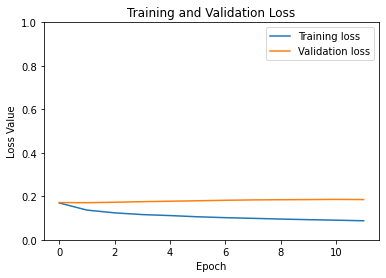

In [ ]:
# Plot the loss of the model
loss = teeth_model.history['loss']
val_loss = teeth_model.history['val_loss']

plt.figure()
plt.plot(teeth_model.epoch, loss, label='Training loss')
plt.plot(teeth_model.epoch, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
# Evaluate model performance on the test set after loading the model
teeth_model = keras.models.load_model('teeth_segmentation.keras', custom_objects={'focal_tversky_loss': focal_tversky_loss})
test_teeth_model = teeth_model.evaluate(test_orig, tf.cast(test_teeth, 'float32'))

In [ ]:
# Save model as .h5 file for use in web application
teeth_model.save('teeth_segmentation.h5', save_format='h5')

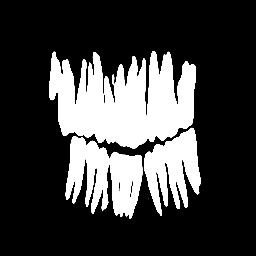

In [ ]:
# Show predicted mask
array_to_img(teeth_model.predict(test_orig)[0])

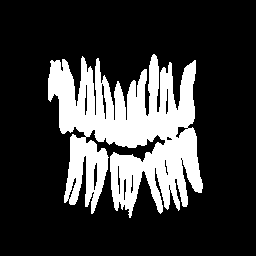

In [ ]:
# Show original mask
array_to_img(test_teeth[0])

<a name="abnormality-model"></a>
## Abnormality Model

In [ ]:
#base.trainable = True - set to true after first round of training with learning rate of 0.001, then set to 0.000001 and run with base.trainable = True
#keras.backend.clear_session()
# Save best model
callback = [
    keras.callbacks.ModelCheckpoint("abnormality_segmentation.keras", 
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss",
                                  patience=10)
]
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=focal_tversky_loss, metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.MeanIoU(num_classes=2)])
# Fit the model on the abnormality data
abnormality_model = model.fit(sub_train_orig, tf.cast(train_ab, 'float32'),
                        epochs=64,
                        batch_size=32,
                        callbacks=callback,
                        validation_data=(sub_val_orig, tf.cast(val_ab, 'float32')))

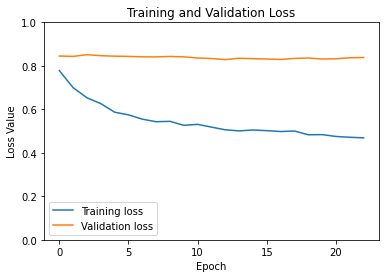

In [ ]:
# Plot the loss of the model
loss = abnormality_model.history['loss']
val_loss = abnormality_model.history['val_loss']

plt.figure()
plt.plot(abnormality_model.epoch, loss, label='Training loss')
plt.plot(abnormality_model.epoch, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
# Evaluate model performance on the test set after loading the model
abnormality_model = keras.models.load_model('abnormality_segmentation.keras', custom_objects={'focal_tversky_loss': focal_tversky_loss})
test_abnormality_model = abnormality_model.evaluate(sub_test_orig, tf.cast(test_ab, 'float32'))

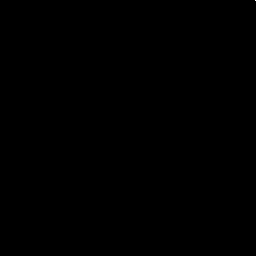

In [ ]:
# Predicted mask
array_to_img(model.predict(sub_test_orig)[10])

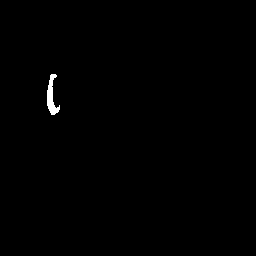

In [ ]:
# Actual mask
array_to_img(test_ab[10])